In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize': (12,7)})

In [3]:
df=pd.read_excel(r'C:\work\for_clustering.xlsx') 

In [4]:
df.head()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,...,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,...,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,...,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,...,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,...,0.042788,1,1,22,3,557.97,1,1,1,1


#### В таблице "for_clustering" есть 2 идентичных столбца _SEGMENT_ и EM_SEGMENT. Вероятно, это уже разделение на кластеры, но мы сделаем по своему

#### Как правило, задача любого бизнеса - это удержать клиентов для получения наибольшей прибыли. Сдлеаем сегментацию клиетов по частоте посещения ресурса на основании столбца Checks_LastMonthqnt. Будем использовать метод k-means

In [5]:
klast_df=df[['Id_client','Checks_LastMonthqnt']]

#### Определим оптимальное количество кластеров, увелиичивая количество кластеров исчитая сумму наименьших квадратов

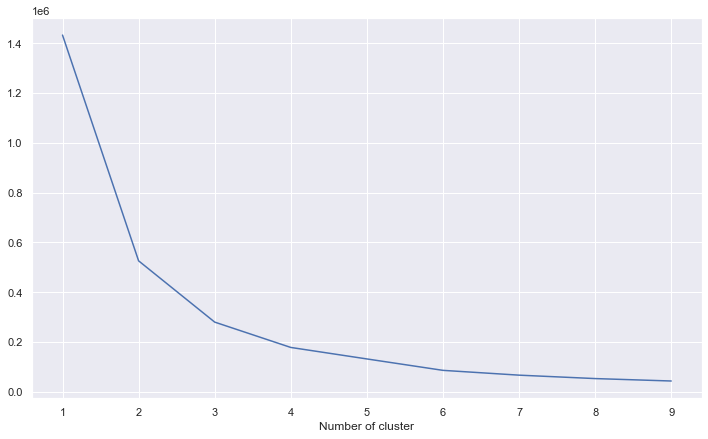

In [6]:
from sklearn.cluster import KMeans
sse={}
tx_recency = klast_df[['Checks_LastMonthqnt']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Как видно из графика - оптимальное количество кластеров = 3. Откластеризуем наши данные и добавим в нашу таблицу

In [7]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(klast_df[['Checks_LastMonthqnt']])
klast_df['ChecksCluster'] = kmeans.predict(klast_df[['Checks_LastMonthqnt']])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
klast_df

,Id_client,Checks_LastMonthqnt,ChecksCluster
0,5743,12,0
1,5756,15,0
2,5781,2,1
3,5801,35,2
4,5808,3,1
...,...,...,...
27503,822495,4,1
27504,822844,5,1
27505,823011,3,1
27506,823218,6,1


#### Создадим функицю для сортировки кластеров, чтобы сделать кластеризацию понятнее,  где 0 - мало посещений, 3 (или больше, в зависимости от числа кластеров - много посещений)

In [9]:
def sort_cluster(data, field, cluster_field, sort_field='Id_client'):
    new=data.sort_values(by=[field]).reset_index()
    k=0
    t=[]
    z=new[cluster_field][0]
    for i in new[cluster_field]:
        if i==z:
            t.append(k)
        else:   
            k+=1
            z=i
            t.append(k)
    new[cluster_field]=t
    new=new.sort_values(by=[sort_field]).reset_index()
    t=new[cluster_field]
    return t

In [10]:
klast_df['ChecksCluster']=sort_cluster(klast_df, 'Checks_LastMonthqnt', 'ChecksCluster')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
klast_df

,Id_client,Checks_LastMonthqnt,ChecksCluster
0,5743,12,1
1,5756,15,1
2,5781,2,0
3,5801,35,2
4,5808,3,0
...,...,...,...
27503,822495,4,0
27504,822844,5,0
27505,823011,3,0
27506,823218,6,0


#### Тоже самое проделаем для общей потраченной клиентом суммой

In [12]:
klast_df['Total_amount']=df['Total_amount']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
klast_df.head()

,Id_client,Checks_LastMonthqnt,ChecksCluster,Total_amount
0,5743,12,1,12398.51
1,5756,15,1,12959.65
2,5781,2,0,2963.88
3,5801,35,2,19676.34
4,5808,3,0,2482.24


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

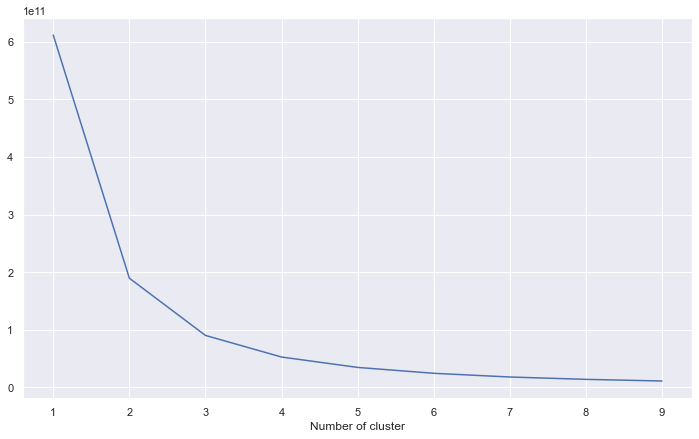

In [14]:
sse={}
tx_recency = klast_df[['Total_amount']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Оптимальное количество кластеров = 3. Откластеризуем пользователей по показателю общей потраченной суммы

In [15]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(klast_df[['Total_amount']])
klast_df['AmountCluster'] = kmeans.predict(klast_df[['Total_amount']])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### С помощью созданной функции отсортируем новые кластеры, где 0 - потратил мало денег, 3 - потратил много

In [16]:
klast_df['AmountCluster'] = sort_cluster(klast_df, 'Total_amount', 'AmountCluster')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### И третий параметр для клкстеризации возьмём общее количество товаров, купленных в Cat_householdchem_qnt, Cat_careproducts_qnt, Cat_toiletries_qnt, Cat_healthwellnes_qnt, Cat_babyprod_qnt


In [17]:
klast_df['qty']=df['Cat_householdchem_qnt']+df['Cat_careproducts_qnt']+df['Cat_toiletries_qnt']+df['Cat_healthwellnes_qnt']+df['Cat_babyprod_qnt']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
klast_df.head()

,Id_client,Checks_LastMonthqnt,ChecksCluster,Total_amount,AmountCluster,qty
0,5743,12,1,12398.51,1,1114
1,5756,15,1,12959.65,1,1024
2,5781,2,0,2963.88,0,170
3,5801,35,2,19676.34,2,2486
4,5808,3,0,2482.24,0,255


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

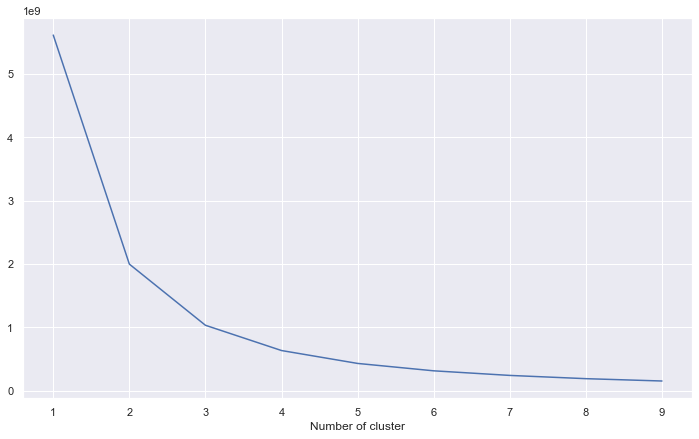

In [19]:
sse={}
tx_recency = klast_df[['qty']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Оптимальное число кластеров = 3. Сделаем все как в предыдущих шагах. Откластеризуем данные по количеству товара и отсортируем кластеры, где 0 - мало товаров, 3 - много товаров

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(klast_df[['qty']])
klast_df['qtyCluster'] = kmeans.predict(klast_df[['qty']])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
klast_df['qtyCluster'] = sort_cluster(klast_df, 'qty', 'qtyCluster')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
klast_df

,Id_client,Checks_LastMonthqnt,ChecksCluster,Total_amount,AmountCluster,qty,qtyCluster
0,5743,12,1,12398.51,1,1114,1
1,5756,15,1,12959.65,1,1024,1
2,5781,2,0,2963.88,0,170,0
3,5801,35,2,19676.34,2,2486,2
4,5808,3,0,2482.24,0,255,0
...,...,...,...,...,...,...,...
27503,822495,4,0,6164.92,0,317,0
27504,822844,5,0,3653.61,0,412,0
27505,823011,3,0,7509.19,0,434,0
27506,823218,6,0,8612.11,1,465,0


#### Как видно из таблицы, кластеры оказались примерно одинаковы. Посчитаем общий счёт всех кластеров

In [23]:
klast_df['OverallScore']=klast_df['ChecksCluster']+klast_df['AmountCluster']+klast_df['qtyCluster']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
klast_df

,Id_client,Checks_LastMonthqnt,ChecksCluster,Total_amount,AmountCluster,qty,qtyCluster,OverallScore
0,5743,12,1,12398.51,1,1114,1,3
1,5756,15,1,12959.65,1,1024,1,3
2,5781,2,0,2963.88,0,170,0,0
3,5801,35,2,19676.34,2,2486,2,6
4,5808,3,0,2482.24,0,255,0,0
...,...,...,...,...,...,...,...,...
27503,822495,4,0,6164.92,0,317,0,0
27504,822844,5,0,3653.61,0,412,0,0
27505,823011,3,0,7509.19,0,434,0,0
27506,823218,6,0,8612.11,1,465,0,1


In [25]:
klast_df['OverallScore'].unique()

array([3, 0, 6, 2, 1, 4, 5], dtype=int64)

#### Приведенная выше оценка ясно показывает нам, что клиенты с 6 баллами - наши лучшие клиенты, а 0 - худшие.
#### Для простоты лучше назвать эти оценки:

#### От 0 до 1: низкое значение
#### От 2 до 3: среднее значение
#### 4+: высокое значение
#### Применим это имя к нашей базе: 

In [26]:
klast_df['Segment'] = 'Low-Value'
klast_df.loc[klast_df['OverallScore']>1,'Segment'] = 'Mid-Value' 
klast_df.loc[klast_df['OverallScore']>3,'Segment'] = 'High-Value' 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [27]:
klast_df.head()

,Id_client,Checks_LastMonthqnt,ChecksCluster,Total_amount,AmountCluster,qty,qtyCluster,OverallScore,Segment
0,5743,12,1,12398.51,1,1114,1,3,Mid-Value
1,5756,15,1,12959.65,1,1024,1,3,Mid-Value
2,5781,2,0,2963.88,0,170,0,0,Low-Value
3,5801,35,2,19676.34,2,2486,2,6,High-Value
4,5808,3,0,2482.24,0,255,0,0,Low-Value


#### Посмотрим средние значения по получившемуся скорингу

In [28]:
klast_df.groupby('OverallScore')['Checks_LastMonthqnt','Total_amount','qty'].mean()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Checks_LastMonthqnt,Total_amount,qty
OverallScore,,,
0,3.750368,5029.044129,361.399338
1,6.958821,7898.343986,550.891198
2,7.855841,10129.925472,805.614747
3,10.296970,12717.092081,987.668013
4,13.984621,14954.698381,1267.284877
5,17.309946,16692.620245,1609.546322
6,27.954861,17745.674340,1815.013889


#### Посмотрим, как наши сегменты распределены по точечной диаграмме: Total_amount-qty, Checks_LastMonthqnt-qty, Checks_LastMonthqnt-Total_amount

Text(0.5, 1.0, 'Total_amount-qty')

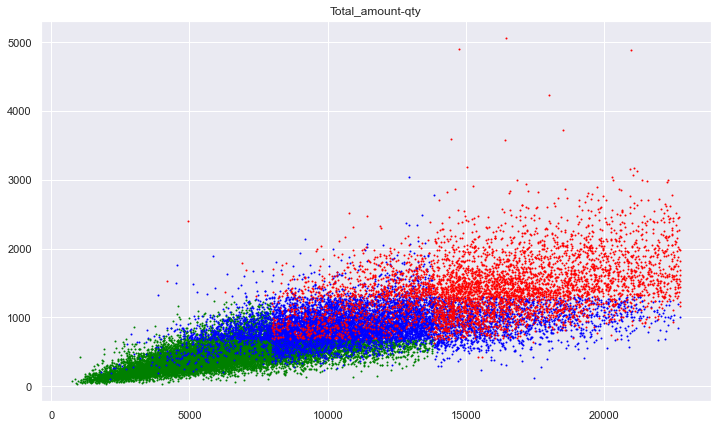

In [29]:
plt.scatter(
    x=klast_df.query("Segment == 'Low-Value'")['Total_amount'],
    y=klast_df.query("Segment == 'Low-Value'")['qty'],
    s=1,
    c='green'
)
plt.scatter(
    x=klast_df.query("Segment == 'Mid-Value'")['Total_amount'],
    y=klast_df.query("Segment == 'Mid-Value'")['qty'],
    s=1,
    c='blue'
)
plt.scatter(
    x=klast_df.query("Segment == 'High-Value'")['Total_amount'],
    y=klast_df.query("Segment == 'High-Value'")['qty'],
    s=1,
    c='red'
)
plt.title('Total_amount-qty')

Text(0.5, 1.0, 'Checks_LastMonth-qty')

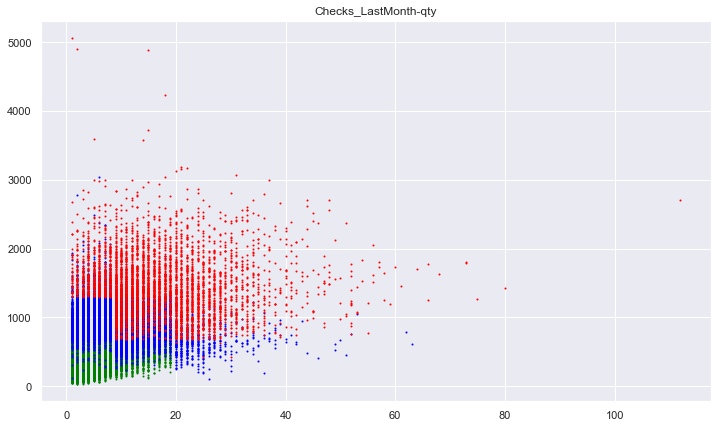

In [30]:
plt.scatter(
    x=klast_df.query("Segment == 'Low-Value'")['Checks_LastMonthqnt'],
    y=klast_df.query("Segment == 'Low-Value'")['qty'],
    s=1,
    c='green'
)
plt.scatter(
    x=klast_df.query("Segment == 'Mid-Value'")['Checks_LastMonthqnt'],
    y=klast_df.query("Segment == 'Mid-Value'")['qty'],
    s=1,
    c='blue'
)
plt.scatter(
    x=klast_df.query("Segment == 'High-Value'")['Checks_LastMonthqnt'],
    y=klast_df.query("Segment == 'High-Value'")['qty'],
    s=1,
    c='red'
)
plt.title('Checks_LastMonth-qty')

Text(0.5, 1.0, 'Checks_LastMonth-Total_amount')

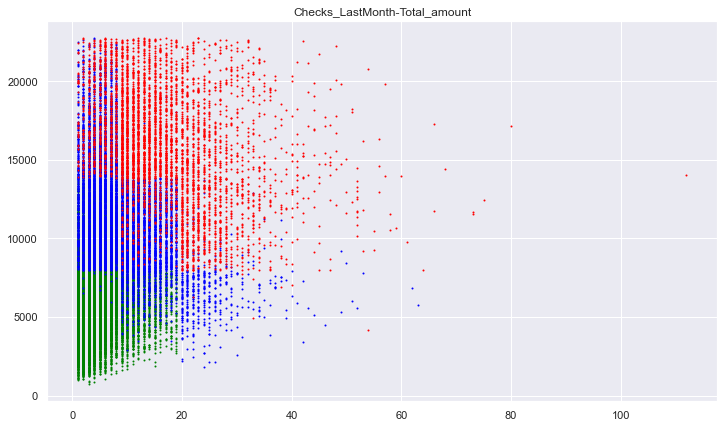

In [31]:
plt.scatter(
    x=klast_df.query("Segment == 'Low-Value'")['Checks_LastMonthqnt'],
    y=klast_df.query("Segment == 'Low-Value'")['Total_amount'],
    s=1,
    c='green'
)
plt.scatter(
    x=klast_df.query("Segment == 'Mid-Value'")['Checks_LastMonthqnt'],
    y=klast_df.query("Segment == 'Mid-Value'")['Total_amount'],
    s=1,
    c='blue'
)
plt.scatter(
    x=klast_df.query("Segment == 'High-Value'")['Checks_LastMonthqnt'],
    y=klast_df.query("Segment == 'High-Value'")['Total_amount'],
    s=1,
    c='red'
)
plt.title('Checks_LastMonth-Total_amount')

На основании наших сегментов можно:

1) Высокое значение: улучшить удержание

2) Среднее значение: улучшение удержания + увеличение частоты

3) Низкое значение: увеличение частоты


### Так как задание творческое - это лишь одно из возможных вариантов сегментации. Данных много, каждые нужно посмотреть, почистить от выбросов и лишних шумов.  Сегментацию необходимо проводить в зависимости от преследуемой цели.